In [ ]:
import copy
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
import torch 
import time
tl.set_backend('pytorch')

In [ ]:
class CP_ALS():
    """
    This class computes the Candecomp PARAFAC decomposition using 
    N-way Alternating least squares algorithm along with khatri rao product
    """
    def moveaxis(self, tensor: torch.Tensor, source: int, destination: int) -> torch.Tensor:
        """
        This method is from the implementation given in pytorch 
        https://github.com/pytorch/pytorch/issues/36048#issuecomment-652786245
        """
        dim = tensor.dim()
        perm = list(range(dim))
        if destination < 0:
            destination += dim
        perm.pop(source)
        perm.insert(destination, source)
        return tensor.permute(*perm)
    
    def unfold_tensor(self, tensor, mode):
        """ This method unfolds the given input tensor along with the specified mode.
        Input :
            tensor : Input tensor
            mode : Specified mode of unfolding
        Output :
            matrix : Unfolded matrix of the tensor with specified mode
        """
        #t = tensor.transpose(mode, 0)
        t = self.moveaxis(tensor, mode, 0)
        matrix = t.reshape(tensor.shape[mode], -1)
        return matrix
        #return torch.reshape(torch.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))

    ## Old functions
    #def perform_Kronecker_Product(self, t1, t2):
    #    t1_flatten = torch.flatten(t1)
    #    op = torch.empty((0, ))
    #    for element in t1_flatten:
    #        output = element*t2
    #        op = torch.cat((op, output))
    #    return op
    
    #def perform_Khatri_Rao_Product(self, t1, t2):
    #    # Check for criteria if the columns of both matrices are same
    #    r1, c1 = t1.shape
    #    r2, c2 = t2.shape
    #    if c1 != c2:
    #        print("Number of columns are different. Product can't be performed")
    #        return 0
    #    opt = torch.empty((r1*r2, c1))
    #    for col_no in range(0, t1.shape[-1]):
    #        x = self.perform_Kronecker_Product(t1[:, col_no], t2[:, col_no])
    #        opt[:, col_no] = x
    #    return opt
    
    # New functions
    def perform_Kronecker_Product(self, A, B):
        """ 
        This method performs the kronecker product of the two matrices
        The method is adaption of the method proposed in https://discuss.pytorch.org/t/kronecker-product/3919/10
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            Output is the resultant matrix after kronecker product
        """
        return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))
    
    def perform_Khatri_Rao_Product(self, A, B):
        """
        This methods performs the Khatri Rao product as it is the column wise kronecker product
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            result : The resultant Khatri-Rao product matrix
        """
        if A.shape[1] != B.shape[1]:
            print("Inputs must have same number of columns")
            return 0
        result = None
        for col in range(A.shape[1]):
            res = self.perform_Kronecker_Product(A[:, col].unsqueeze(0), B[:, col].unsqueeze(0))
            if col == 0:
                result = res
            else:
                result = torch.cat((result, res), dim = 0)
        return result.T

    def compute_MTTKRP(self, tensor_matrix, A, k_value):
        """
        This method computes the Matricized Tensor Times Khatri-Rao product
        between the unfolded tensor and the all other factors apart from kth factor.
        Input : 
            tensor_matrix : Unfolded tensor as a matrix
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            B : Resultant MTTKRP matrix
        """
        A_matrix = copy.deepcopy(A)
        A_matrix.pop(k_value)
        krp_matrix = A_matrix[0]
        for index in range(1, len(A_matrix)):
            krp_matrix = self.perform_Khatri_Rao_Product(krp_matrix, A_matrix[index])
        B = torch.matmul(tensor_matrix, krp_matrix)
        return B
    
    def compute_V_Matrix(self, A, k_value):
        """
        This method computes the V value as a hadamard product of 
        outer product of every factort matrix apart from kth factor matrix.
        Input : 
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            v : Resultant V matrix after the hadamard product
        """
        A_matrix = copy.deepcopy(A)
        A_matrix.pop(k_value)
        v = torch.matmul(A_matrix[0].T, A_matrix[0])
        for index in range(1, len(A_matrix)):
            p = torch.matmul(A_matrix[index].T, A_matrix[index])
            v = v*p
        return v
    
    def create_A_Matrix(self, tensor_shape, rank):
        """
        This method generates required number of factor matrices.
        Input : 
            tensor_shape : shape of the input tensor
            rank : Required rank of the factors
        Output : 
            A : Resultant list of factor matrices
        """
        A = []
        for i in tensor_shape:
            A.append(torch.randn((i, rank)))
        return A
    
    def compute_ALS(self, input_tensor, max_iter, rank):
        """
        This method is heart of this algorithm, this computes the factors and also lambdas of the algorithm.
        Input : 
            input_tensor : Tensor containing input values
            max_iter : maximum number of iterations
            rank : prescribed rank of the resultant factors
        Output : 
            A : factor matrices
            lmbds : column norms of each factor matrices
        """
        A = self.create_A_Matrix(input_tensor.shape, rank)
        lmbds = []
        for l_iter in range(0, max_iter):
            for k in range(0, len(A)):
                X_unfolded = self.unfold_tensor(input_tensor, k)
                Z = self.compute_MTTKRP(X_unfolded, A, k)
                V = self.compute_V_Matrix(A, k)
                A_k = torch.matmul(Z, torch.pinverse(V))
                l = torch.norm(A_k, dim=0)
                d_l = np.zeros((rank, rank))
                np.fill_diagonal(d_l, l)
                #A_k = np.dot(A_k, np.linalg.pinv(d_l))
                if l_iter == 0:
                    lmbds.append(np.linalg.norm(l))
                else:
                    lmbds[k] = np.linalg.norm(l)
                A[k] = A_k
        return A, lmbds
    
    def reconstruct_tensor(self, factors, norm, rank, ip_shape):
        """
        This method reconstructs the tensor given factor matrices and norms
        Input : 
            factors : factor matrices
            norm : column norms of every factor matrices
            rank : prescribed rank of the resultant factors
            ip_shape : Input tensor shape 
        Output : 
            M : Reconstructed tensor
        """
        M = 0       
        for c in range(0, rank):
            op = factors[0][:, c]
            for i in range(1, len(factors)):
                op = np.outer(op.T, factors[i][:, c])
            M += op
        M = np.reshape(M, ip_shape)
        return M

    def reconstruct_Three_Way_Tensor(self, a, b, c):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

    # Reconstruct the tensor from the factors
    def reconstruct_Four_Way_Tensor(self, a, b, c, d):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
            d : Fourth factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            Y = (torch.ger(a[:, index], b[:, index]).unsqueeze(2)*c[:, index]).unsqueeze(3)*d[:,index].unsqueeze(0).unsqueeze(0)
            x_t += Y
            #x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

In [ ]:
ip_shape = (256, 64, 11, 11)
r_state = 0
max_iter = 100   
r = 64
torch.manual_seed(0)
X_tensor = torch.randn(ip_shape)

In [ ]:
cp_als = CP_ALS()

In [ ]:
start = time.time()
A, lmbds =  cp_als.compute_ALS(X_tensor, max_iter, r)
end = time.time()
print("Run time in seconds: ", end-start)

In [ ]:
print(A[0].shape)
print(A[1].shape)
print(A[2].shape)
print(A[3].shape)

In [ ]:
recon_tensor = cp_als.reconstruct_Three_Way_Tensor(A[0], A[1], A[2])

In [ ]:
print(recon_tensor)

In [ ]:
start = time.time()
X = parafac(X_tensor, r, n_iter_max= max_iter, init="random", verbose=True)[1]
end = time.time()
print("Run time: ", end-start)

In [ ]:
recon_tensor_tl = cp_als.reconstruct_Three_Way_Tensor(X[0], X[1], X[2])

In [ ]:
print(recon_tensor_tl)

In [ ]:
print(X[0], X[1], X[2])

## Graphs for presentation

In [18]:
#from CP_N_Way_Decomposition import CP_ALS
from tensorly.decomposition import parafac
import torch
import tensorly as tl
import numpy as np
#import matplotlib
#matplotlib.use('AGG')
#matplotlib.rcParams['text.usetex'] = True
tl.set_backend('pytorch')

In [19]:
ones = torch.randn((2, 3, 3))
print(ones)

tensor([[[-1.4192, -0.5040,  0.4957],
         [-0.9996,  0.8199,  0.6812],
         [ 1.0946, -2.0008,  0.7139]],

        [[ 0.6136,  1.2167, -0.5914],
         [-0.0321,  1.2354, -0.4008],
         [ 0.2624,  1.1269,  0.4031]]])


In [40]:
class CP_ALS():
    """
    This class computes the Candecomp PARAFAC decomposition using 
    N-way Alternating least squares algorithm along with khatri rao product
    """
    def moveaxis(self, tensor, source, destination):
        """
        This method is from the implementation given in pytorch https://github.com/pytorch/pytorch/issues/36048#issuecomment-652786245
        Input : 
            tensor : Input tensor
            source : First axis to move
            destination : Second axis to replace the first one
        Output :
            Output tensor to where the axis is moved
        """
        dim = tensor.dim()
        perm = list(range(dim))
        if destination < 0:
            destination += dim
        perm.pop(source)
        perm.insert(destination, source)
        return tensor.permute(*perm)
    
    def unfold_tensor(self, tensor, mode):
        """ This method unfolds the given input tensor along with the specified mode.
        Input :
            tensor : Input tensor
            mode : Specified mode of unfolding
        Output :
            matrix : Unfolded matrix of the tensor with specified mode
        """
        t = self.moveaxis(tensor, mode, 0)
        matrix = t.reshape(tensor.shape[mode], -1)
        return matrix
    
    #def perform_Kronecker_Product(self, t1, t2):
    #    t1_flatten = torch.flatten(t1)
    #    op = torch.empty((0, ))
    #    for element in t1_flatten:
    #        output = element*t2
    #        op = torch.cat((op, output))
    #    return op
    
    #def perform_Khatri_Rao_Product(self, t1, t2):
    #    # Check for criteria if the columns of both matrices are same
    #    r1, c1 = t1.shape
    #    r2, c2 = t2.shape
    #    if c1 != c2:
    #        print("Number of columns are different. Product can't be performed")
    #        return 0
    #    opt = torch.empty((r1*r2, c1))
    #    for col_no in range(0, t1.shape[-1]):
    #        x = self.perform_Kronecker_Product(t1[:, col_no], t2[:, col_no])
    #        opt[:, col_no] = x
    #    return opt

    def perform_Kronecker_Product(self, A, B):
        """ 
        This method performs the kronecker product of the two matrices
        The method is adaption of the method proposed in https://discuss.pytorch.org/t/kronecker-product/3919/10
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            Output is the resultant matrix after kronecker product
        """
        return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))
    
    def perform_Khatri_Rao_Product(self, A, B):
        """
        This methods performs the Khatri Rao product as it is the column wise kronecker product
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            result : The resultant Khatri-Rao product matrix
        """
        if A.shape[1] != B.shape[1]:
            print("Inputs must have same number of columns")
            return 0
        result = None
        for col in range(A.shape[1]):
            res = self.perform_Kronecker_Product(A[:, col].unsqueeze(0), B[:, col].unsqueeze(0))
            if col == 0:
                result = res
            else:
                result = torch.cat((result, res), dim = 0)
        return result.T

    def compute_MTTKRP(self, tensor_matrix, A, k_value):
        """
        This method computes the Matricized Tensor Times Khatri-Rao product
        between the unfolded tensor and the all other factors apart from kth factor.
        Input : 
            tensor_matrix : Unfolded tensor as a matrix
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            B : Resultant MTTKRP matrix
        """
        #A_matrix = copy.deepcopy(A)
        #A_matrix.pop(k_value)
        krp_matrix = A[0]
        for index in range(1, len(A)):
            krp_matrix = self.perform_Khatri_Rao_Product(krp_matrix, A[index])
        B = torch.matmul(tensor_matrix, krp_matrix)
        return B
    
    def compute_fit(self, X, M):
        diff = X-M
        fit = (np.linalg.norm(diff))/(np.linalg.norm(X))
        return fit
    
    def compute_V_Matrix(self, A, k_value):
        """
        This method computes the V value as a hadamard product of 
        outer product of every factort matrix apart from kth factor matrix.
        Input : 
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            v : Resultant V matrix after the hadamard product
        """
        #A_matrix = copy.deepcopy(A)
        #A_matrix.pop(k_value)
        v = torch.matmul(A[0].T, A[0])
        for index in range(1, len(A)):
            p = torch.matmul(A[index].T, A[index])
            v = v*p
        return v
    
    def create_A_Matrix(self, tensor_shape, rank):
        """
        This method generates required number of factor matrices.
        Input : 
            tensor_shape : shape of the input tensor
            rank : Required rank of the factors
        Output : 
            A : Resultant list of factor matrices
        """
        A = []
        for i in tensor_shape:
            A.append(torch.randn((i, rank)))
        return A
    
    def compute_ALS(self, input_tensor, max_iter, rank):
        """
        This method is heart of this algorithm, this computes the factors and also lambdas of the algorithm.
        Input : 
            input_tensor : Tensor containing input values
            max_iter : maximum number of iterations
            rank : prescribed rank of the resultant factors
        Output : 
            A : factor matrices
            lmbds : column norms of each factor matrices
        """
        A = self.create_A_Matrix(input_tensor.shape, rank)
        lmbds = []
        fit_list = []
        for l_iter in range(0, max_iter):
            for k in range(0, len(A)):
                X_unfolded = self.unfold_tensor(input_tensor, k)
                A.pop(k)
                Z = self.compute_MTTKRP(X_unfolded, A, k)
                V = self.compute_V_Matrix(A, k)
                A_k = torch.matmul(Z, torch.pinverse(V))
                #l = torch.norm(A_k, dim=0)
                #d_l = np.zeros((rank, rank))
                #np.fill_diagonal(d_l, l)
                #A_k = np.dot(A_k, np.linalg.pinv(d_l))
                #if l_iter == 0:
                #    lmbds.append(np.linalg.norm(l))
                #else:
                #    lmbds[k] = np.linalg.norm(l)
                #A[k] = A_k
                A.insert(k, A_k)
            if l_iter%5 == 0:
                M = self.reconstruct_Three_Way_Tensor(A[0], A[1], A[2])
                fit_val = self.compute_fit(input_tensor, M)
                fit_list.append([l_iter, fit_val])
        return A, lmbds, fit_list
    
    def reconstruct_tensor(self, factors, norm, rank, ip_shape):
        """
        This method reconstructs the tensor given factor matrices and norms
        Input : 
            factors : factor matrices
            norm : column norms of every factor matrices
            rank : prescribed rank of the resultant factors
            ip_shape : Input tensor shape 
        Output : 
            M : Reconstructed tensor
        """
        M = 0       
        for c in range(0, rank):
            op = factors[0][:, c]
            for i in range(1, len(factors)):
                op = np.outer(op.T, factors[i][:, c])
            M += op
        M = np.reshape(M, ip_shape)
        return M

    def reconstruct_Three_Way_Tensor(self, a, b, c):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

    # Reconstruct the tensor from the factors
    def reconstruct_Four_Way_Tensor(self, a, b, c, d):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
            d : Fourth factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            Y = (torch.ger(a[:, index], b[:, index]).unsqueeze(2)*c[:, index]).unsqueeze(3)*d[:,index].unsqueeze(0).unsqueeze(0)
            x_t += Y
            #x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

In [41]:
# parameters
r = 2
max_iter = 101
als = CP_ALS()

In [42]:
A, lmbds, f_list = als.compute_ALS(ones, max_iter, r)

In [43]:
print(A)
print(f_list[-1])

[tensor([[-0.3008,  0.5871],
        [ 0.2954, -0.0256]]), tensor([[ 3.9065,  2.0330],
        [ 2.5978,  2.6058],
        [ 1.8892, -2.4003]]), tensor([[ 0.2799, -0.7384],
        [ 1.3142,  1.0169],
        [-0.5219, -0.0465]])]
[100, 0.31077987]


In [44]:
m_recons = als.reconstruct_Three_Way_Tensor(A[0], A[1], A[2])

In [45]:
print(m_recons)
print()
print(ones)

tensor([[[-1.2103, -0.3307,  0.5578],
         [-1.3484,  0.5286,  0.3366],
         [ 0.8815, -2.1799,  0.3622]],

        [[ 0.3615,  1.4637, -0.5998],
         [ 0.2641,  0.9407, -0.3974],
         [ 0.1108,  0.7960, -0.2941]]])

tensor([[[-1.4192, -0.5040,  0.4957],
         [-0.9996,  0.8199,  0.6812],
         [ 1.0946, -2.0008,  0.7139]],

        [[ 0.6136,  1.2167, -0.5914],
         [-0.0321,  1.2354, -0.4008],
         [ 0.2624,  1.1269,  0.4031]]])


In [46]:
A_tl = parafac(ones, rank=r, n_iter_max=max_iter, init="random", verbose=True)[1]

reconstruction error=0.6505117416381836
iteration 1,  reconstraction error: 0.5159079432487488, decrease = 0.13460379838943481, unnormalized = 2.047833204269409
iteration 2,  reconstraction error: 0.5053101778030396, decrease = 0.010597765445709229, unnormalized = 2.0057666301727295
iteration 3,  reconstraction error: 0.4983913004398346, decrease = 0.006918877363204956, unnormalized = 1.978303074836731
iteration 4,  reconstraction error: 0.48912376165390015, decrease = 0.009267538785934448, unnormalized = 1.9415167570114136
iteration 5,  reconstraction error: 0.4731593132019043, decrease = 0.01596444845199585, unnormalized = 1.878147840499878
iteration 6,  reconstraction error: 0.4395270347595215, decrease = 0.03363227844238281, unnormalized = 1.7446485757827759
iteration 7,  reconstraction error: 0.3713935613632202, decrease = 0.06813347339630127, unnormalized = 1.4742012023925781
iteration 8,  reconstraction error: 0.32454413175582886, decrease = 0.04684942960739136, unnormalized = 1

In [47]:
print(A_tl)

[tensor([[ 3.7983, -4.4157],
        [-0.1637,  4.3405]]), tensor([[-0.3551,  0.5931],
        [-0.4554,  0.3942],
        [ 0.4200,  0.2873]]), tensor([[ 0.6529,  0.1258],
        [-0.8981,  0.5889],
        [ 0.0410, -0.2339]])]


In [48]:
m_recons_tl = als.reconstruct_Three_Way_Tensor(A_tl[0], A_tl[1], A_tl[2])
print(m_recons_tl)
print()
print(ones)

tensor([[[-1.2102, -0.3308,  0.5573],
         [-1.3483,  0.5285,  0.3363],
         [ 0.8820, -2.1798,  0.3621]],

        [[ 0.3618,  1.4638, -0.5998],
         [ 0.2639,  0.9406, -0.3971],
         [ 0.1120,  0.7961, -0.2945]]])

tensor([[[-1.4192, -0.5040,  0.4957],
         [-0.9996,  0.8199,  0.6812],
         [ 1.0946, -2.0008,  0.7139]],

        [[ 0.6136,  1.2167, -0.5914],
         [-0.0321,  1.2354, -0.4008],
         [ 0.2624,  1.1269,  0.4031]]])


In [4]:
ones = torch.randn((3, 64, 192))
r = 190
r = [50, 100, 150, 180, 190, 210]
max_iter = 100

In [5]:
f_l = []
for index in range(len(r)):
    _, _, f = als.compute_ALS(ones, max_iter, r[index])
    f_l.append(f)

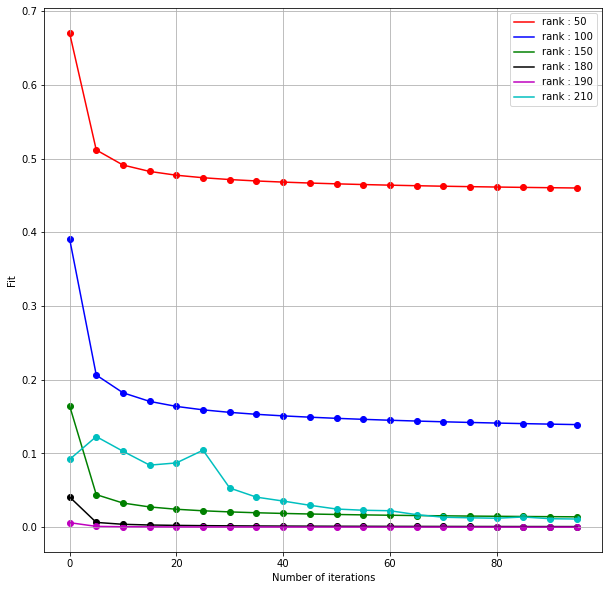

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = ['r', 'b', 'g', 'k', 'm', 'c']
for index, f_list in enumerate(f_l):
    x = []
    y = []
    clr = colors[index]
    for i in f_list:
        plt.scatter(i[0], i[1], c=clr)
        x.append(i[0])
        y.append(i[1])
    lbl = "rank : "+str(r[index])
    plt.plot(x, y, c=clr, label = lbl)
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Fit")
plt.grid()
plt.show()

In [ ]:
A, _, f = als.compute_ALS(ones, max_iter, 150)

In [ ]:
print(torch.matrix_rank(A[2]))
print(A[1].shape)

In [ ]:
print(torch.matrix_rank(ones[0, :, :]))

In [21]:
ones = torch.randn((2, 3, 3))
r = [1, 2, 3]
#r = [50, 100, 150, 180, 190, 210]
max_iter = 100

In [22]:
_, _, f1 = als.compute_ALS(ones, max_iter, 1)
_, _, f2 = als.compute_ALS(ones, max_iter, 2)
_, _, f3 = als.compute_ALS(ones, max_iter, 3)

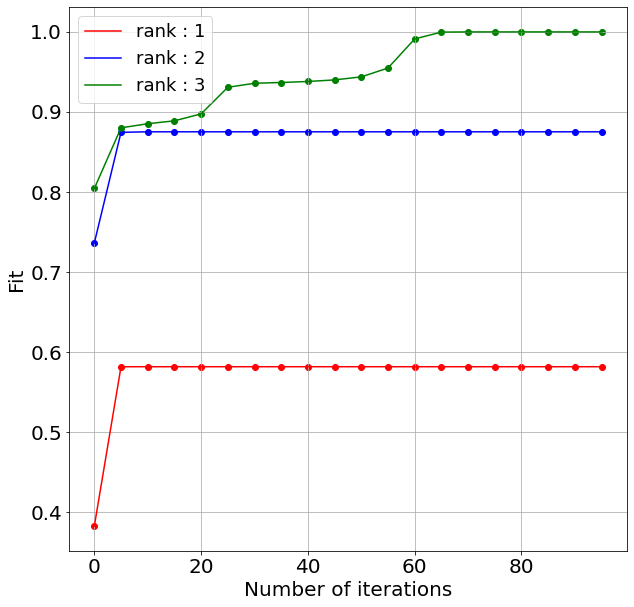

In [34]:
import matplotlib.pyplot as plt
f_l = [f1, f2, f3]
plt.figure(figsize=(10, 10))
colors = ['r', 'b', 'g', 'k', 'm', 'c']
for index, f_list in enumerate(f_l):
    x = []
    y = []
    clr = colors[index]
    for i in f_list:
        plt.scatter(i[0], 1-i[1], c=clr)
        x.append(i[0])
        y.append(1-i[1])
    lbl = "rank : "+str(r[index])
    plt.plot(x, y, c=clr, label = lbl)
plt.legend(fontsize=18)
#ylbl = r"\TeX\ Fit $\frac{||X-M||^2}{||X||^2}$"
ylbl = "Fit"
plt.xlabel("Number of iterations", fontsize=20)
plt.ylabel(ylbl, fontsize=20)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("Multirank.png", dpi=400)
plt.show()